In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})

## Summary

* no missing data
* different satelites have different number of observations (max is 6320, min is 94)
* there are strong systematic nonlinear(!) discrepancies between simaluted and real values for coordinates and for speeds. The shape of deviation looks like lissajou figures (but may have nothing to do with them) 
* there is obvious 'dephasing' between simulated and real values. That is, in the beginning of the simulations, the matching between is almost perfect, but at the end of simulation there is clear phase difference.
* the model for simulation does not include the gradual change of the orbit radius and the speed (scalar)
* the spread of speeds (V_max - V_min) is underestimated in many cases (almost never overestimated)
* second-order correction to EOM works for the data !!!!

In [3]:
data = pd.read_csv('train.csv', index_col= 'id')
data.head(3)

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768


In [395]:
# data.info()

In [394]:
# # checking missing values
# data.isna().sum(axis = 'rows')

In [7]:
sat_obs = data.sat_id.value_counts()
print('maxinum number of observations: {}'.format(sat_obs.max()))
print('minimum number of observations: {}'.format(sat_obs.min()))

maxinum number of observations: 6320
minimum number of observations: 94


Text(0, 0.5, 'x')

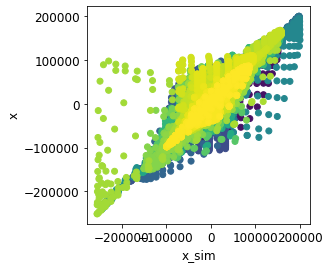

In [393]:
# see how different the simulated coordinates from predicted
plt.figure(figsize=(4,4))
plt.scatter(data.x_sim,data.x,c=data.sat_id)
plt.xlabel("x_sim")
plt.ylabel("x")

Text(0, 0.5, 'Vx')

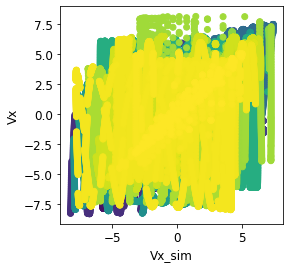

In [392]:
# see how different the simulated coordinates from predicted

plt.figure(figsize=(4,4))
plt.scatter(data.Vx_sim,data.Vx,c=data.sat_id)
plt.xlabel("Vx_sim")
plt.ylabel("Vx")

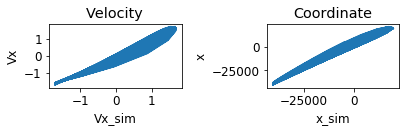

In [391]:
# let us look at a single satelite
data_sat = data[data.sat_id == 300]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2), linewidth = 0.1)
ax1.plot(data_sat.Vx_sim,data_sat.Vx)
ax1.set_title("Velocity")
ax1.set_xlabel("Vx_sim")
ax1.set_ylabel("Vx")
ax2.plot(data_sat.x_sim,data_sat.x)
ax2.set_title("Coordinate")
ax2.set_xlabel("x_sim")
ax2.set_ylabel("x")
plt.tight_layout()


# Looking at the satelite with the largest data points

Text(0, 0.5, 'Vx')

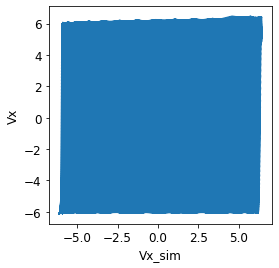

In [390]:
# let's look at the data for the satelite with the larget amount of data
m_id = sat_obs.sort_values().index[-1]
m_data = data[data.sat_id == m_id]

plt.figure(figsize=(4,4))
plt.plot(m_data.Vx_sim,m_data.Vx)
plt.xlabel("Vx_sim")
plt.ylabel("Vx")

Text(0, 0.5, 'x')

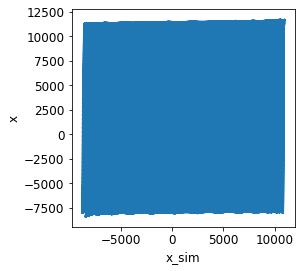

In [389]:
plt.figure(figsize=(4,4))
plt.plot(m_data.x_sim,m_data.x)
plt.xlabel("x_sim")
plt.ylabel("x")

In [105]:
# low let's consider it as a time series
m_data.epoch = pd.to_datetime(m_data.epoch[:,])
m_data.set_index('epoch', inplace = True)
m_data.head()

c:\users\tatiana\anaconda3\envs\idao\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
epoch,,,,,,,,,,,,,
2014-01-01 00:00:00.000,372,-7864.678484,-3129.694640,2907.635431,-2.245256,6.608261,1.039890,-7860.046460,-3132.109662,2904.845788,-2.248154,6.610960,1.041413
2014-01-01 00:07:03.869,372,-8412.117022,-220.195147,3197.249996,-0.322000,7.005179,0.317406,-8408.384650,-221.380394,3195.033561,-0.323371,7.008780,0.318784
2014-01-01 00:14:07.738,372,-8142.359815,2712.345768,3175.824997,1.569116,6.723347,-0.411696,-8138.889636,2712.535682,3174.147312,1.569253,6.726703,-0.410586
2014-01-01 00:21:11.606,372,-7118.319697,5395.817612,2859.815398,3.207649,5.855679,-1.061148,-7114.320644,5397.827305,2858.516662,3.208626,5.859393,-1.059693
2014-01-01 00:28:15.475,372,-5478.816040,7618.661585,2296.340781,4.454570,4.574468,-1.571567,-5474.803399,7620.801613,2295.605579,4.455283,4.576093,-1.570595


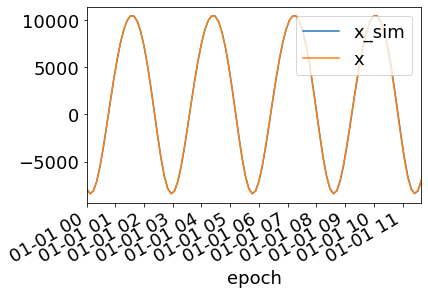

In [106]:
m_data[:100].x_sim.plot(label = 'x_sim')
m_data[:100].x.plot(label = 'x')
plt.legend(loc = 1)

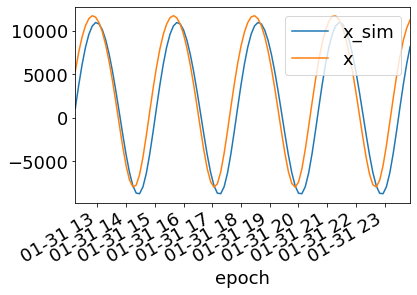

In [107]:
m_data[-100:].x_sim.plot(label = 'x_sim')
m_data[-100:].x.plot(label = 'x')
plt.legend(loc = 1)

Looks like the phase and the offset between the simulation and the real value are changing with time.

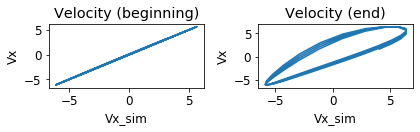

In [388]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2), linewidth = 0.1)
ax1.plot(m_data[:100].Vx_sim,m_data[:100].Vx)
ax1.set_title("Velocity (beginning)")
ax1.set_xlabel("Vx_sim")
ax1.set_ylabel("Vx")

ax2.plot(m_data[-100:].Vx_sim,m_data[-100:].Vx)
ax2.set_title("Velocity (end)")
ax2.set_xlabel("Vx_sim")
ax2.set_ylabel("Vx")
plt.tight_layout()

616.4860685179954


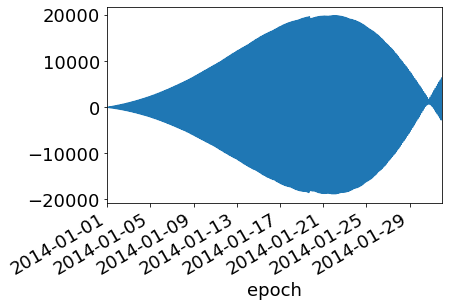

In [109]:
difference = m_data.x-m_data.x_sim
print(difference.mean())
difference[:].plot()

## Evolution of radius

In [246]:
m_id = sat_obs.sort_values().index[200]
m_data = data[data.sat_id == m_id]

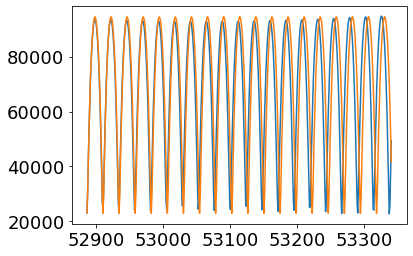

In [247]:
r = np.sqrt(m_data.x**2+m_data.y**2+m_data.z**2)
r_sim = np.sqrt(m_data.x_sim**2+m_data.y_sim**2+m_data.z_sim**2)
plt.plot(r[:])
plt.plot(r_sim[:])

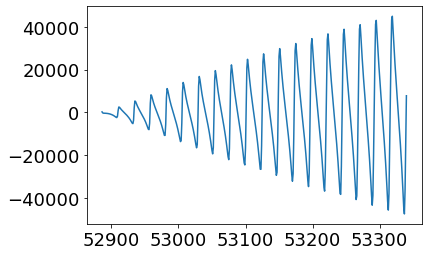

In [248]:
plt.plot(r-r_sim)

We can see that the model for simulation does not include the gradual increase of radius.

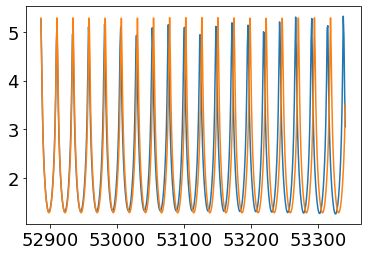

In [249]:
speed = np.sqrt(m_data.Vx**2+m_data.Vy**2+m_data.Vz**2)
speed_sim = np.sqrt(m_data.Vx_sim**2+m_data.Vy_sim**2+m_data.Vz_sim**2)
plt.plot(speed)
plt.plot(speed_sim)

# Let's look at Fourier transform

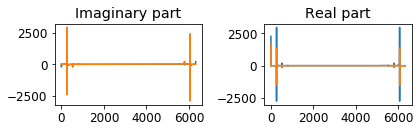

In [387]:
s = np.fft.ifft(m_data.x)
s_sim = np.fft.ifft(m_data.x_sim)
t = np.arange(len(m_data.x))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2), linewidth = 0.1)
ax1.set_title("Imaginary part")
ax1.plot(t, s.imag)
ax1.plot(t, s_sim.imag)

ax2.set_title("Real part")
ax2.plot(t, s.real)
ax2.plot(t, s_sim.real)

plt.tight_layout()

(-250, 250)

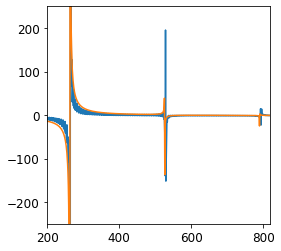

In [385]:
plt.figure(figsize=(4,4))
plt.plot(t, s.real)
plt.plot(t, s_sim.real)
plt.xlim([200,820])
plt.ylim([-250,250])

(-250, 250)

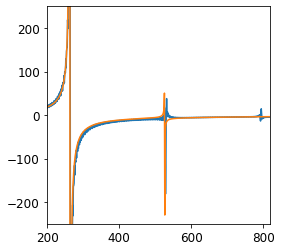

In [384]:
plt.figure(figsize=(4,4))
plt.plot(t, s.imag)
plt.plot(t, s_sim.imag)
plt.xlim([200,820])
plt.ylim([-250,250])

# Distribution of orbit radii 

In [258]:
data['radius'] = np.sqrt(data.x**2+data.y**2+data.z**2)
data['radius_sim'] = np.sqrt(data.x_sim**2+data.y_sim**2+data.z_sim**2)

data['speed'] = np.sqrt(data.Vx**2+data.Vy**2+data.Vz**2)
data['speed_sim'] = np.sqrt(data.Vx_sim**2+data.Vy_sim**2+data.Vz_sim**2)

In [259]:
orbits = data.groupby('sat_id').agg({'radius':['max','min','mean'],
                                     'radius_sim':['max','min','mean'],
                                     'speed':['max','min','mean'],
                                     'speed_sim':['max','min','mean'],
                                     'epoch':['count']
                                    })
orbits.head()

radius                                 radius_sim  \
                  max           min          mean            max   
sat_id                                                             
0        45456.138231  26055.667966  37089.673093   45435.618165   
1        33145.178842   9480.338813  24043.492758   30996.602074   
2        88525.178417  35946.367097  67593.872562   88483.865249   
3       113037.471222  25800.000000  83386.906541  113128.505398   
4        40864.306203  20345.080776  32285.104148   40856.798043   

                                       speed                     speed_sim  \
                 min          mean       max       min      mean       max   
sat_id                                                                       
0       26066.565345  37078.116172  4.409858  2.527665  3.274538  4.408323   
1       11221.720940  23437.131825  8.074972  2.274235  4.023999  7.222133   
2       35999.113542  67569.020677  3.971576  1.613108  2.421667  3.967548   
3       25746.357849  83402.369379  5.015947  1.145381  2.130393  5.022338   
4       20345.825704  32296.162950  5.114521  2.546358  3.509986  5.114330   

                           epoch  
             min      mean count  
sat_id                            
0       2.529023  3.275160   958  
1       2.614980  4.093842  2108  
2       1.614284  2.422313   417  
3       1.143397  2.130242   354  
4       2.546816  3.508198  1210

Text(0, 0.5, 'real')

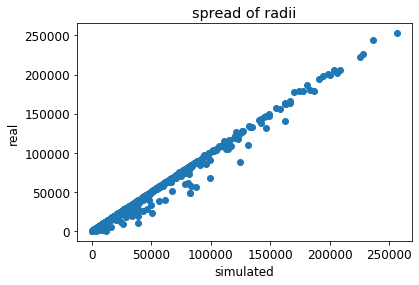

In [398]:
plt.scatter(orbits.radius['max']-orbits.radius['min'],orbits.radius_sim['max']- orbits.radius_sim['min'])
plt.title('spread of radii')
plt.xlabel('simulated')
plt.ylabel('real')

(0.9, 3)

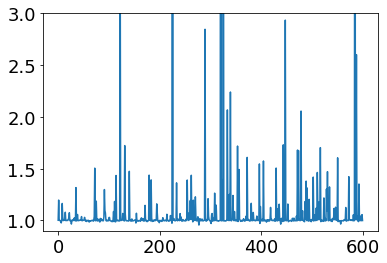

In [200]:
# plt.plot((orbits.radius['max']-orbits.radius['min'])/(orbits.radius_sim['max']-orbits.radius_sim['min'])/orbits.epoch['count'])
plt.plot((orbits.radius['max']-orbits.radius['min'])/(orbits.radius_sim['max']-orbits.radius_sim['min']))
plt.ylim([0.9,3])
# plt.ylim([0,0.01])

(0.9, 3)

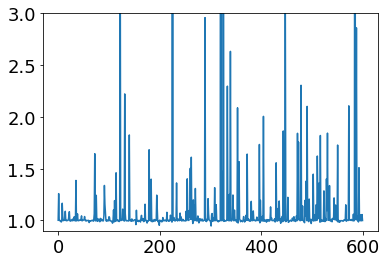

In [201]:
plt.plot((orbits.speed['max']-orbits.speed['min'])/(orbits.speed_sim['max']-orbits.speed_sim['min']))
plt.ylim([0.9,3])

Text(0.5, 1.0, 'distribution of radii')

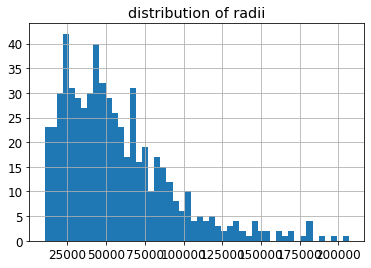

In [399]:
# distribution of radii
orbits.radius['mean'].hist(bins =50)
plt.title('distribution of radii')

Text(0, 0.5, '# on time observations')

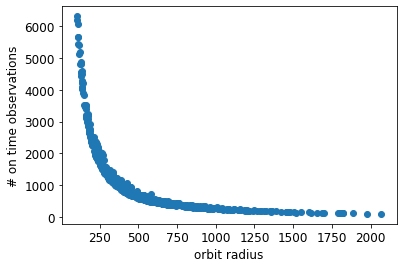

In [403]:
plt.scatter(x = orbits.radius['mean']/100, y = orbits.epoch['count'])
plt.xlabel('orbit radius')
plt.ylabel('# on time observations')

# Equation of motion

In [422]:
# let us again consider the orbit with the largest number of observations
m_id = sat_obs.sort_values().index[-1]
# m_id = 0
m_data = data[data.sat_id == m_id].reset_index(drop=True)
m_data['epoch_days'] = ((pd.to_datetime(m_data.loc[:,'epoch'])- pd.to_datetime(m_data.loc[0,'epoch']))/ np.timedelta64(1, 'D')).astype(float)
m_data.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,radius,radius_sim,speed,speed_sim,epoch_days
0,2014-01-01T00:00:00.000,372,-7864.678484,-3129.694640,2907.635431,-2.245256,6.608261,1.039890,-7860.046460,-3132.109662,2904.845788,-2.248154,6.610960,1.041413,8950.000000,8945.868898,7.056320,7.059995,0.000000
1,2014-01-01T00:07:03.869,372,-8412.117022,-220.195147,3197.249996,-0.322000,7.005179,0.317406,-8408.384650,-221.380394,3195.033561,-0.323371,7.008780,0.318784,9001.922364,8997.676431,7.019755,7.023474,0.004906
2,2014-01-01T00:14:07.738,372,-8142.359815,2712.345768,3175.824997,1.569116,6.723347,-0.411696,-8138.889636,2712.535682,3174.147312,1.569253,6.726703,-0.410586,9150.994882,9147.381346,6.916286,6.919514,0.009812
3,2014-01-01T00:21:11.606,372,-7118.319697,5395.817612,2859.815398,3.207649,5.855679,-1.061148,-7114.320644,5397.827305,2858.516662,3.208626,5.859393,-1.059693,9378.905433,9376.631343,6.760475,6.763928,0.014718
4,2014-01-01T00:28:15.475,372,-5478.816040,7618.661585,2296.340781,4.454570,4.574468,-1.571567,-5474.803399,7620.801613,2295.605579,4.455283,4.576093,-1.570595,9660.983931,9660.222278,6.575620,6.577001,0.019624


In [423]:
m_data['dt'] = m_data['epoch_days'].diff()
for c in ('x','y','z'):
    m_data['{}_diff'.format(c)] = m_data['{}'.format(c)].diff()
    m_data['{}_sim_diff'.format(c)] = m_data['{}_sim'.format(c)].diff()
    m_data['V{}_s'.format(c)] = 0.5*(m_data['V{}'.format(c)]+m_data['V{}'.format(c)].shift(1))
    m_data['V{}_sim_s'.format(c)] = 0.5*(m_data['V{}_sim'.format(c)]+m_data['V{}_sim'.format(c)].shift(1))

In [424]:
m_data.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,...,Vx_s,Vx_sim_s,y_diff,y_sim_diff,Vy_s,Vy_sim_s,z_diff,z_sim_diff,Vz_s,Vz_sim_s
0,2014-01-01T00:00:00.000,372,-7864.678484,-3129.694640,2907.635431,-2.245256,6.608261,1.039890,-7860.046460,-3132.109662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-01T00:07:03.869,372,-8412.117022,-220.195147,3197.249996,-0.322000,7.005179,0.317406,-8408.384650,-221.380394,...,-1.283628,-1.285763,2909.499493,2910.729269,6.806720,6.809870,289.614565,290.187773,0.678648,0.680099
2,2014-01-01T00:14:07.738,372,-8142.359815,2712.345768,3175.824997,1.569116,6.723347,-0.411696,-8138.889636,2712.535682,...,0.623558,0.622941,2932.540915,2933.916076,6.864263,6.867742,-21.424999,-20.886250,-0.047145,-0.045901
3,2014-01-01T00:21:11.606,372,-7118.319697,5395.817612,2859.815398,3.207649,5.855679,-1.061148,-7114.320644,5397.827305,...,2.388383,2.388939,2683.471844,2685.291623,6.289513,6.293048,-316.009600,-315.630650,-0.736422,-0.735140
4,2014-01-01T00:28:15.475,372,-5478.816040,7618.661585,2296.340781,4.454570,4.574468,-1.571567,-5474.803399,7620.801613,...,3.831109,3.831954,2222.843973,2222.974308,5.215073,5.217743,-563.474617,-562.911083,-1.316358,-1.315144


Check if $ x_{t+1} = x_{t} + 0.5(v_{t+1}+v_{t})dt$. This is a second order correction for the EOM

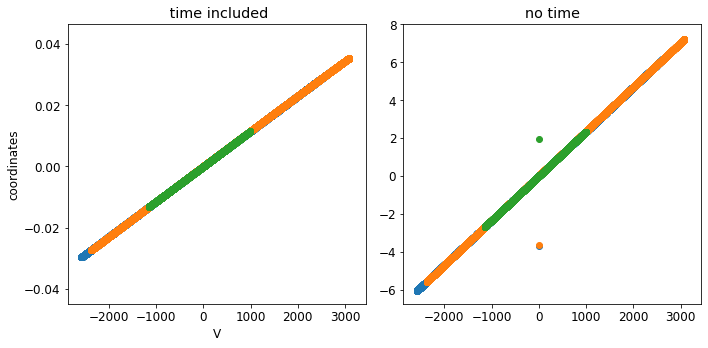

In [425]:
# for real data

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.scatter(m_data.x_diff, m_data.Vx_s*m_data.dt)
ax1.scatter(m_data.y_diff, m_data.Vy_s*m_data.dt)
ax1.scatter(m_data.z_diff, m_data.Vz_s*m_data.dt)
ax1.set_title(' time included')
ax1.set_xlabel('V*dt')
ax1.set_ylabel('coordinates')

ax2.scatter(m_data.x_diff, m_data.Vx_s)
ax2.scatter(m_data.y_diff, m_data.Vy_s)
ax2.scatter(m_data.z_diff, m_data.Vz_s)
ax2.set_title('no time')
ax1.set_xlabel('V')

plt.tight_layout()


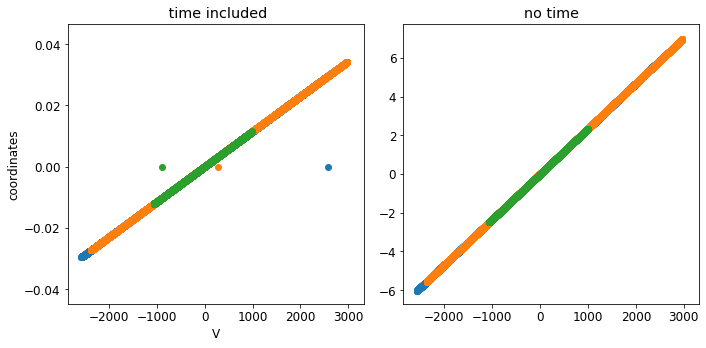

In [426]:
# for simulated data


f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.scatter(m_data.x_sim_diff, m_data.Vx_sim_s*m_data.dt)
ax1.scatter(m_data.y_sim_diff, m_data.Vy_sim_s*m_data.dt)
ax1.scatter(m_data.z_sim_diff, m_data.Vz_sim_s*m_data.dt)
ax1.set_title(' time included')
ax1.set_xlabel('V*dt')
ax1.set_ylabel('coordinates')

ax2.scatter(m_data.x_sim_diff, m_data.Vx_sim_s)
ax2.scatter(m_data.y_sim_diff, m_data.Vy_sim_s)
ax2.scatter(m_data.z_sim_diff, m_data.Vz_sim_s)
ax2.set_title('no time')
ax1.set_xlabel('V')

plt.tight_layout()


Except for one(several for other satellites) odd point the equation holds for bot real and simulated data. Thus, we only need to worry about getting correction for the velocities.